# Brain Tissue Segmentation using Expectation-Maximization (EM) Algorithm
***Submitted by: Md Imran Hossain and Muhammad Zain Amin***
<br>Erasmus Mundus Joint Master in Meidcal Imaging and Applications
<br>University of Girona, Spain

In [1]:
# Install the SimpleITK library
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 17.7 MB/s eta 0:00:00


In [2]:
# Import necessary Libraries
import time
import logging
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
from pathlib import Path
from tqdm import tqdm
from sklearn.cluster import KMeans
from google.colab import drive
from typing import List, Union, Tuple
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Mount the google drive with colab
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Define the path of data directory
data_path = Path('/content/drive/MyDrive/Colab Notebooks/MISA/Lab 02/P2_data')

In [27]:
# Function for Min Max Normalization
def min_max_normalization(image_data, maximum_value=None, dtype=None):
    """
    Perform min-max normalization on the input image data.

    Args:
        image_data (array_like): Input image data as a NumPy array or array-like object.
        maximum_value (int, optional): The maximum value after normalization. If not provided, it is set to the maximum value of the data type of image_data. Defaults to None.
        dtype (data-type, optional): The data type of the returned array. If not provided, the data type remains the same as the input. Defaults to None.

    Returns:
        array_like: Normalized image data as a NumPy array. If dtype is specified, the data type of the array is converted accordingly.
    """

    # Convert input to a NumPy array
    image_data = np.array(image_data)

    # If maximum_value is not provided, set it to the maximum value of the data type of image_data
    if maximum_value is None:
        maximum_value = np.iinfo(image_data.dtype).max

    # Apply min-max normalization to the image data
    image_data = (image_data - image_data.min()) / (image_data.max() - image_data.min()) * maximum_value

    # If dtype is provided, convert the image data to the specified data type
    if dtype is not None:
        return image_data.astype(dtype)
    else:
        return image_data



# Function for Gaussian Likelihood
def gaussian_likelihood(image_data, means, co_var):
    """
    Calculate the Gaussian likelihood of the image data given means and covariance matrices.

    Args:
        image_data (array_like): Input image data as a NumPy array or array-like object.
        means (array_like): Means of the Gaussian distribution as a NumPy array.
        co_var (array_like): Covariance matrices of the Gaussian distribution as a NumPy array.

    Returns:
        array_like: Gaussian likelihood values for the image data with respect to each component.
    """

    # Convert inputs to NumPy arrays
    image_data = np.array(image_data)
    means = np.array(means)
    co_var = np.array(co_var)

    # Determine the number of components
    n_components, _ = means.shape

    # Initialize an empty array for likelihood values
    likelihood = np.empty((len(image_data), n_components))

    # Calculate likelihood for each component
    for i in range(n_components):
        likelihood[:, i] = multivariate_normal.pdf(image_data, means[i, :], co_var[i, :, :], allow_singular=True)

    return likelihood




# Function for Matching predicted labels with the ground truth
def prediction_matching(prediction, groundtruth_mask, t1_image_array, t2_image_array: np.ndarray = None):
    """
    Match predictions to ground truth masks based on tissue intensities.

    Args:
        prediction (array_like): Predicted image data as a NumPy array or array-like object.
        groundtruth_mask (array_like): Ground truth mask as a NumPy array or array-like object.
        t1_image_array (array_like): T1 image data as a NumPy array or array-like object.
        t2_image_array (array_like, optional): T2 image data as a NumPy array or array-like object. Defaults to None.

    Returns:
        array_like: Matched predictions based on tissue intensities.
    """

    # Convert inputs to NumPy arrays
    prediction = np.array(prediction)
    groundtruth_mask = np.array(groundtruth_mask)
    t1_image_array = np.array(t1_image_array)

    # Initialize the container for matched predictions
    matched_predictions = np.zeros_like(prediction)
    original_shape = prediction.shape
    prediction = prediction.flatten()
    groundtruth_mask = groundtruth_mask.flatten()

    if t2_image_array is not None:
        data = np.array([t1_image_array.flatten(), t2_image_array.flatten()]).T
        n_features = 2
    else:
        n_features = 1
        data = t1_image_array.flatten()[:, np.newaxis]

    # Get the available labels
    predicted_labels = np.unique(prediction[prediction != 0])
    n_components = len(predicted_labels)

    # Get means of tissue intensities in each class under gt or prediction masks
    means_pred = np.zeros((n_components, n_features))
    means_gt = np.zeros((n_components, n_features))
    for label in range(n_components):
        means_pred[label, :] = np.mean(data[prediction == label+1, :], axis=0)
        means_gt[label, :] = np.mean(data[groundtruth_mask == label+1, :], axis=0)

    # Compare the mean intensity of each class (euclidean distance)
    dists = np.zeros((n_components, n_components))
    for i in range(n_components):
        for j in range(n_components):
            dists[i, j] = np.linalg.norm(means_pred[i, :] - means_gt[j, :])

    # Match classes according to closer mean intensity value
    gt_match = np.argmin(dists, axis=1)
    prediction = prediction.reshape(original_shape)

    # Relabel image
    for i in range(n_components):
        matched_label = gt_match[i] + 1
        matched_predictions[prediction == i+1] = matched_label

    return matched_predictions



# Function for Brain Tissue Segmentation
def segmentation(t1_image, t2_image, mask, seg_mode, mean_init='kmeans', seed=420):
    """
    Perform segmentation on T1 and T1+T2 images based on the provided mode.

    Args:
        t1_image (array_like): T1 image data as a NumPy array or array-like object.
        t2_image (array_like): T2 image data as a NumPy array or array-like object.
        mask (array_like): Mask as a NumPy array or array-like object.
        seg_mode (str): Segmentation mode, either 'em' for Expectation Maximization or 'kmeans' for KMeans.
        mean_init (str, optional): Initialization method for means. Defaults to 'kmeans'.
        seed (int, optional): Seed value for random number generation. Defaults to 420.

    Returns:
        tuple: A tuple containing T1 segmentation, T1+T2 segmentation, time taken for T1 segmentation,
        time taken for T1+T2 segmentation, T1 iteration count, and T1+T2 iteration count.
    """

    t1_image = np.array(t1_image)
    t2_image = np.array(t2_image)
    mask = np.array(mask)
    t1_image_vector = t1_image[mask == 255].flatten()
    t2_image_vector = t2_image[mask == 255].flatten()

    # T1 segmentation (Single modality)
    data = np.array(t1_image_vector)[:, np.newaxis]
    if seg_mode == 'em':
        model = ExpectationMaximization(n_components=3, mean_init=mean_init, priors='non_informative', plot_rate=None, seed=seed)
    else:
        model = KMeans(n_clusters=3, random_state=seed)

    start = time.time()
    preds = model.fit_predict(data)
    t_t1 = time.time() - start
    predictions = mask.flatten()
    predictions[predictions == 255] = preds + 1
    t1_segmentation_reshape = predictions.reshape(t1_image.shape)
    t1_iterations = model.n_iter_


    # T1 + T2 segmentation (Multi modality)
    data = np.array([t1_image_vector, t2_image_vector]).T
    if seg_mode == 'em':
        model = ExpectationMaximization(n_components=3, mean_init=mean_init, priors='non_informative', plot_rate=None, seed=seed)
    else:
        model = KMeans(n_clusters=3, random_state=seed)

    start = time.time()
    preds = model.fit_predict(data)
    t_t1_t2_image = time.time() - start
    predictions = mask.flatten()
    predictions[predictions == 255] = preds + 1
    t1_t2_image_segmentation_reshape = predictions.reshape(t1_image.shape)
    t1_t2_image_iterations = model.n_iter_

    return t1_segmentation_reshape, t1_t2_image_segmentation_reshape, t_t1, t_t1_t2_image, t1_iterations, t1_t2_image_iterations


# Function for computing the Dice Score
def dice_score(groundtruth_image, segmented_image):
    """
    Compute the Dice score for each class in the segmented image compared to the ground truth.

    Args:
        groundtruth_image (array_like): Ground truth image data as a NumPy array or array-like object.
        segmented_image (array_like): Segmented image data as a NumPy array or array-like object.

    Returns:
        list: List of Dice scores for each class in the segmented image compared to the ground truth.
    """

    groundtruth_image = np.array(groundtruth_image)
    segmented_image = np.array(segmented_image)

    # Get the unique classes in the ground truth image
    classes = np.unique(groundtruth_image[groundtruth_image != 0])

    # Initialize an array to store the Dice scores for each class
    dice = np.zeros((len(classes)))

    # Compute the Dice score for each class
    for i in classes:
        # Convert to binary masks
        binary_prediction = np.where(segmented_image == i, 1, 0)
        binary_groundtruth = np.where(groundtruth_image == i, 1, 0)

        # Compute the Dice score
        dice[i-1] = np.sum(binary_prediction[binary_groundtruth == 1]) * 2.0 / (np.sum(binary_prediction) + np.sum(binary_groundtruth))

    # Convert the array to a list and return
    return dice.tolist()



# Function for Plotting images
def plots(volumes: List[np.ndarray], names: List[str], slice_n: int = 20):
    """
    Display slices from multiple 3D volumes in a row.

    Args:
        volumes (List[np.ndarray]): List of 3D volume arrays.
        names (List[str]): List of names for the volumes.
        slice_n (int, optional): Slice number to be displayed. Defaults to 20.
    """
    n = len(volumes)  # Number of volumes

    # Create a figure with subplots
    fig, ax = plt.subplots(1, n, figsize=(20, 5))

    # Iterate over each volume
    for i in range(n):
        # Set the title for each subplot
        ax[i].set_title(names[i])

        # Display the specified slice of the volume
        ax[i].imshow(volumes[i][slice_n, :, :], cmap='gray')

        # Remove axis ticks
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    # Show the plot
    plt.show()


In [26]:
# Class for the Expectation-Maximization (EM) Model
class ExpectationMaximization():
    def __init__(self, n_components=3, mean_init='kmeans', priors='non_informative',
                 max_iter=100, change_tol=1e-6, seed=42, plot_rate=None):

        """
        A class implementing the Expectation-Maximization algorithm for Gaussian Mixture Models.

        Args:
            n_components (int): Number of components in the Gaussian Mixture Model.
            mean_init (str): Method for initializing means, either 'kmeans' or 'random'.
            priors (str): Type of prior, either 'non_informative' or 'custom'.
            max_iter (int): Maximum number of iterations for the algorithm.
            change_tol (float): Tolerance for considering convergence.
            seed (int): Seed value for random number generation.
            plot_rate (int): Rate for plotting convergence (optional).
        """
        # Initialize the class attributes
        self.n_components = n_components
        self.mean_init = mean_init
        self.priors = priors
        self.max_iter = max_iter
        self.change_tol = change_tol
        self.seed = seed
        self.fitted = False
        self.plot_rate = None
        self.cluster_centers_ = None
        self.n_iter_ = 0

    def fit(self, image_data):
        self.image_data = np.array(image_data)
        self.n_feat = image_data.shape[1] if image_data.ndim > 1 else 1
        self.n_samples = len(image_data)
        self.labels = np.zeros((self.n_samples, self.n_components))

        # Initialize priors as non-informative
        self.priors = np.ones((self.n_components, 1)) / self.n_components

        # Initialize means using k-means
        kmeans = KMeans(n_clusters=self.n_components, random_state=self.seed).fit(self.image_data)
        self.means = kmeans.cluster_centers_
        self.labels[np.arange(self.n_samples), kmeans.labels_] = 1

        # Initialize covariance matrices
        self.means, self.co_var, self.counts = self.estimate_mean_and_cov(self.image_data, self.labels, start_single_cov=True)
        self.expectation_maximization()
        self.cluster_centers_ = self.means
        self.fitted = True

    def predict_probability(self, image_data):
        self.image_data = np.array(image_data)
        self.expectation()
        return self.responsibilities

    def predict(self, image_data):
        self.image_data = np.array(image_data)
        self.expectation()
        self.predictions = np.argmax(self.responsibilities, 1)
        return self.predictions

    def fit_predict(self, image_data):
        self.image_data = np.array(image_data)
        self.fit(image_data)
        self.predictions = self.predict(self.image_data)
        return self.predictions

    def expectation(self):
        self.likelihood = gaussian_likelihood(self.image_data, self.means, self.co_var)
        num = np.asarray([self.likelihood[:, j] * self.priors[j] for j in range(self.n_components)]).T
        denominator = np.sum(num, 1)
        self.responsibilities = np.asarray([num[:, j] / denominator for j in range(self.n_components)]).T

    def maximization(self):
        # Redefine labels with maximum a responsibilities
        self.labels = np.zeros((self.image_data.shape[0], self.n_components))
        self.labels[np.arange(self.n_samples), np.argmax(self.responsibilities, axis=1)] = 1

        # Get means
        self.responsibilities = self.responsibilities * self.labels
        self.counts = np.sum(self.responsibilities, 0)
        weighted_avg = np.dot(self.responsibilities.T, self.image_data)

        # Get means
        self.means = weighted_avg / self.counts[:, np.newaxis]

        # Get covariances
        self.co_var = np.zeros((self.n_components, self.n_feat, self.n_feat))
        for i in range(self.n_components):
            difference = self.image_data - self.means[i, :]
            weighted_diff = self.responsibilities[:, i][:, np.newaxis] * difference
            self.co_var[i] = np.dot(weighted_diff.T, difference) / self.counts[i]

        # Get mixing components
        self.priors = self.counts / len(self.image_data)

    def expectation_maximization(self):
        previous_log_likelihood = 0
        for it in tqdm(range(self.max_iter), desc='Iteration Progressing'):
            self.n_iter_ = it + 1

            # E-step
            self.expectation()

            # Convergence Criteria
            for i in range(self.n_components):
                self.likelihood[:, i] = self.likelihood[:, i] * self.priors[i]
            log_likelihood = np.sum(np.log(np.sum(self.likelihood, 1)))
            error = abs(previous_log_likelihood - log_likelihood)
            previous_log_likelihood = log_likelihood
            if error < self.change_tol:
                break

            # M-Step
            self.maximization()



    @staticmethod
    def estimate_mean_and_cov(image_data, labels, cov_reg=1e-6, start_single_cov=False):
        image_data = np.array(image_data)
        labels = np.array(labels)
        n_components = labels.shape[1]
        n_feat = image_data.shape[1]
        min_val = 10 * np.finfo(labels.dtype).eps
        counts = np.sum(labels, axis=0) + min_val
        means = np.dot(labels.T, image_data) / counts[:, np.newaxis]

        co_var = np.zeros((n_components, n_feat, n_feat))

        if start_single_cov:
            new_covar = np.cov((image_data - np.mean(image_data, axis=0)).T)
            co_var[:] = new_covar
            co_var[:, np.arange(n_feat), np.arange(n_feat)] += cov_reg
        else:
            for i in range(n_components):
                difference = image_data - means[i, :]
                co_var[i] = np.dot((labels[:, i][:, np.newaxis] * difference).T, difference) / counts[i]
                co_var[i, np.arange(n_feat), np.arange(n_feat)] += cov_reg

        if co_var.ndim == 1:
            co_var = co_var[:, np.newaxis, np.newaxis]

        parameters = (means, co_var, counts)
        return parameters

In [28]:
# Read the ground truth images and creat mask
for i in tqdm(range(5), desc='Creating Mask Progressing'):
    # Construct the path to the label image
    label_path = data_path / f'{i+1}/LabelsForTesting.nii'

    # Read the brain label image using SimpleITK
    brain_mask = sitk.ReadImage(label_path)

    # Convert the label image to a NumPy array and threshold it
    bm_array = sitk.GetArrayFromImage(brain_mask)
    bm_array = np.where(bm_array > 0, 255, 0).astype('uint8')

    # Create a new SimpleITK image from the NumPy array
    img = sitk.GetImageFromArray(bm_array)

    # Set the image metadata (direction, origin, spacing) from the original label image
    img.SetDirection(brain_mask.GetDirection())
    img.SetOrigin(brain_mask.GetOrigin())
    img.SetSpacing(brain_mask.GetSpacing())

    # Construct the path to save the brain mask image
    output_path = data_path / f'{i+1}/brain_mask.nii'

    # Write the brain mask image to the specified path
    sitk.WriteImage(img, output_path)

Creating Mask Progressing: 100%|██████████| 5/5 [00:00<00:00, 17.49it/s]


 -----**Image Data 1 Segmentation is Progressing**-----



Iteration Progressing:  66%|██████▌   | 66/100 [00:15<00:08,  4.19it/s]


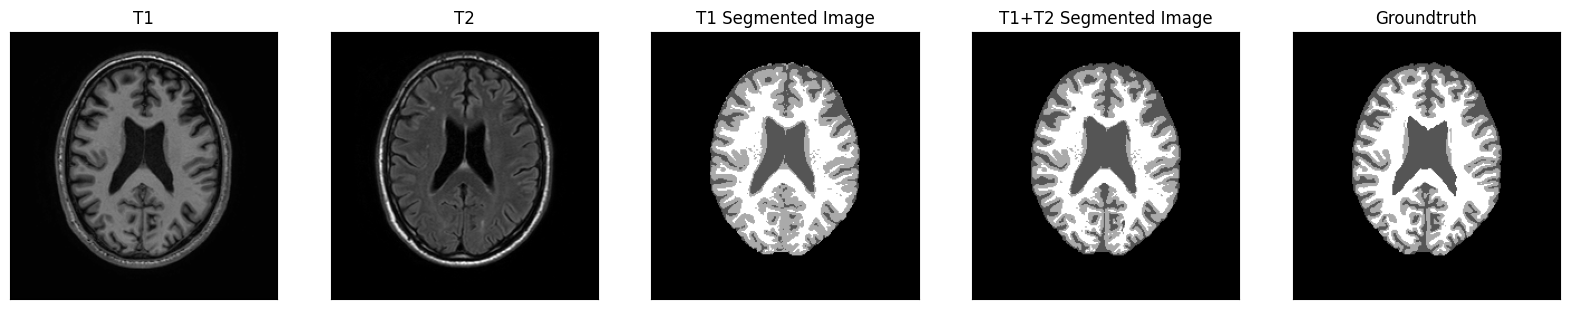

 -----**Image Data 2 Segmentation is Progressing**-----



Iteration Progressing:  66%|██████▌   | 66/100 [00:16<00:08,  4.08it/s]


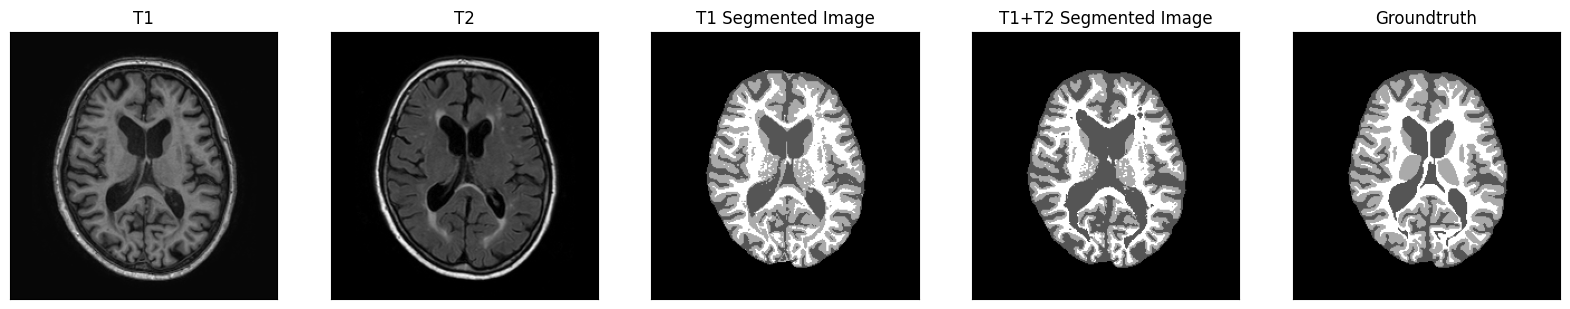

 -----**Image Data 3 Segmentation is Progressing**-----



Iteration Progressing:  65%|██████▌   | 65/100 [00:13<00:07,  4.68it/s]


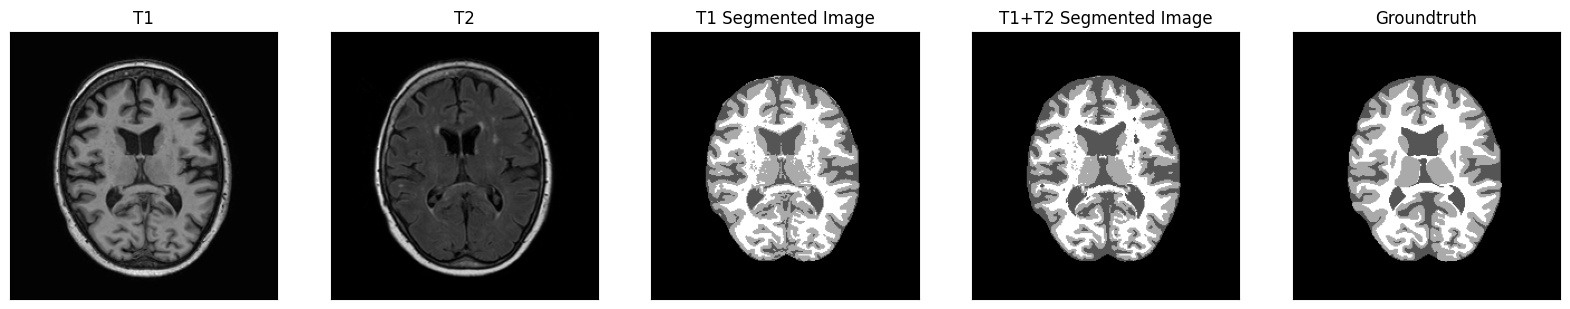

 -----**Image Data 4 Segmentation is Progressing**-----



Iteration Progressing:  51%|█████     | 51/100 [00:10<00:09,  5.00it/s]


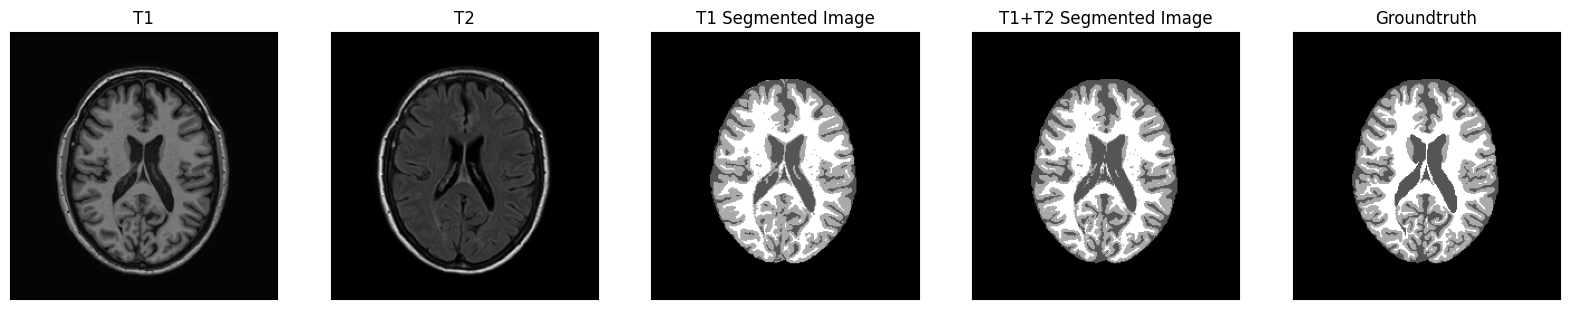

 -----**Image Data 5 Segmentation is Progressing**-----



Iteration Progressing:  43%|████▎     | 43/100 [00:10<00:14,  4.06it/s]


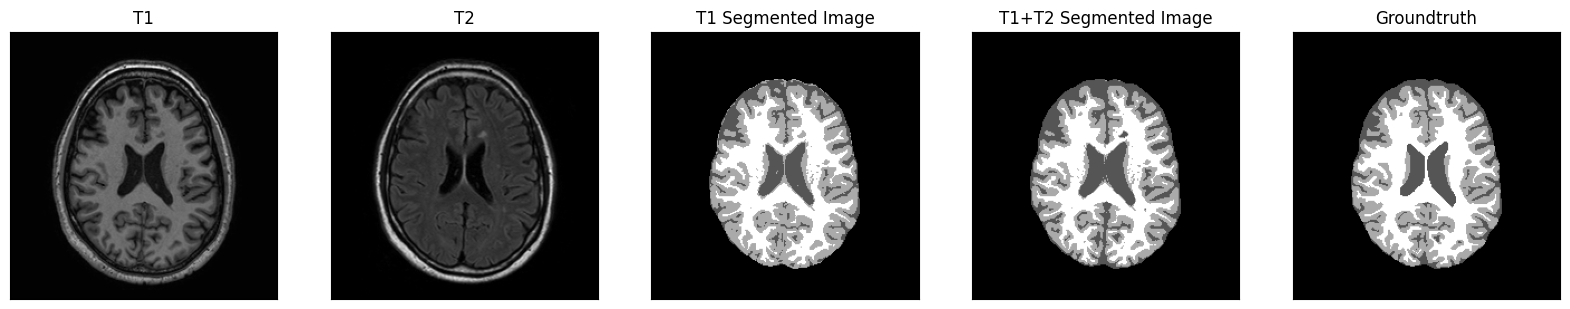

In [29]:
# Create an empty list to store dice scores
dice_scores = []

# Define the columns for the dice_scores DataFrame
columns = ['Data', 'Modalities', 'Time (sec)', 'Iterations','CSF', 'GM', 'WM']

# Load image and perform segmentatoin
for i in range(5):
    print(f' -----**Image Data {i + 1} Segmentation is Progressing**-----\n')

    # Load images for the current subject
    t1_image = sitk.ReadImage(data_path / f'{i+1}/T1.nii')
    t2_image = sitk.ReadImage(data_path / f'{i+1}/T2_FLAIR.nii')
    gt_image = sitk.ReadImage(data_path / f'{i+1}/LabelsForTesting.nii')
    mask     = sitk.ReadImage(data_path / f'{i+1}/brain_mask.nii')


    # Get arrays from the loaded images
    t1_image_array = sitk.GetArrayFromImage(t1_image)
    t2_image_array = sitk.GetArrayFromImage(t2_image)
    groundtruth_array = sitk.GetArrayFromImage(gt_image)
    mask_array = sitk.GetArrayFromImage(mask)

    # Normalize arrays to uint8
    t1_image_array = min_max_normalization(t1_image_array, 255, 'uint8')
    t2_image_array = min_max_normalization(t2_image_array, 255, 'uint8')

    # Segment Brain using EM and k-means
    t1_seg_res_em_km, t1_t2_seg_res_em_km, t_t1_em_km, t_t1_t2_em_km, its_t1_em_km, its_t1_t2_em_km = \
        segmentation(t1_image_array, t2_image_array, mask_array, 'em', 'kmeans')

    # Correct labels to match ground truth
    t1_seg_res_em_km = prediction_matching(t1_seg_res_em_km, groundtruth_array, t1_image_array)
    t1_t2_seg_res_em_km = prediction_matching(t1_t2_seg_res_em_km, groundtruth_array, t1_image_array, t2_image_array)

    # Calculate and store dice scores for T1 and T1+T2_FLAIR
    dice_scores.append([ i+1, 'T1', t_t1_em_km, its_t1_em_km] + dice_score(groundtruth_array, t1_seg_res_em_km) )
    dice_scores.append([ i+1, 'T1+T2_FLAIR', t_t1_t2_em_km, its_t1_t2_em_km] + dice_score(groundtruth_array, t1_t2_seg_res_em_km))

    # Plot the images
    volumes = [t1_image_array, t2_image_array, t1_seg_res_em_km, t1_t2_seg_res_em_km, groundtruth_array]
    names = ['T1', 'T2', 'T1 Segmented Image', 'T1+T2 Segmented Image', 'Groundtruth']
    plots(volumes, names, slice_n=25)

In [32]:
# Create a DataFrame from dice_scores and save it to a CSV file
dice_scores = pd.DataFrame(data=dice_scores, columns=columns)
dice_scores

,Data,Modalities,Time (sec),Iterations,CSF,GM,WM
0,1,T1,7.892773,52,0.817784,0.788215,0.865067
1,1,T1+T2_FLAIR,17.677806,67,0.909960,0.827377,0.862504
2,2,T1,7.719845,38,0.864575,0.796962,0.801900
3,2,T1+T2_FLAIR,18.511336,67,0.804852,0.746076,0.802366
4,3,T1,7.105576,35,0.849056,0.794987,0.863371
5,3,T1+T2_FLAIR,15.944412,66,0.859077,0.779626,0.850481
6,4,T1,7.014464,36,0.863247,0.823121,0.873879
7,4,T1+T2_FLAIR,12.045600,52,0.903458,0.839407,0.873996
8,5,T1,7.536478,45,0.842512,0.859535,0.901282
9,5,T1+T2_FLAIR,12.477115,44,0.872022,0.852464,0.896804


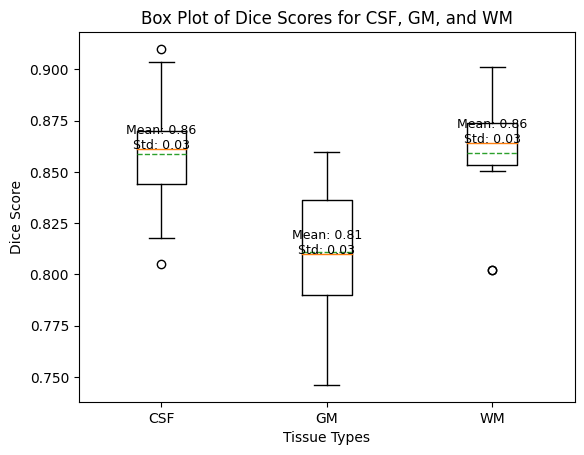

In [43]:
# Extracting the required columns for the box plot
data_to_plot = [dice_scores['CSF'], dice_scores['GM'], dice_scores['WM']]

# Creating a box plot
box = plt.boxplot(data_to_plot, labels=['CSF', 'GM', 'WM'], showmeans=True, meanline=True)

# Adding mean and standard deviation indicators
for i, line in enumerate(box['medians']):
    y = line.get_ydata()
    x = i + 1
    plt.text(x, y[1], f'Mean: {np.mean(data_to_plot[i]):.2f}\nStd: {np.std(data_to_plot[i]):.2f}',
             horizontalalignment='center', fontsize=9)

# Adding title and labels
plt.title('Box Plot of Dice Scores for CSF, GM, and WM')
plt.xlabel('Tissue Types')
plt.ylabel('Dice Score')

# Show the plot
plt.show()

********************The END*************************